# Text Classification

## Package Imports

all of the followin packages come preinstalled with colab (except transformers). There is a try-except block to handle that part.

Please note that you need to upload the `Problem_Dataset.csv` to the session Files on the left side in order to run the notebook.

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

try:
    from transformers import BertTokenizer, TFBertForSequenceClassification
except:
    !pip install transformers -q
    from transformers import BertTokenizer, TFBertForSequenceClassification

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

import seaborn as sns
import matplotlib.pyplot as plt

## Helper Functions

this also includes a function to load models, where it checks the global env variable TRAIN and loads model if the models are present in the file system. Please upload the contents of `saved_models/` from the [repository](https://github.com/visalakshi2001/gra-ml-task/tree/main/saved_models) to the session files directly to avoid re-running the training parts.

In [37]:
def read_and_split_data(return_one_hot = True, random_state=101):
    df = pd.read_csv('/content/Problem_Dataset.csv')

    if return_one_hot:
        df_ = pd.DataFrame()
        df_["Obs"] = df["Obs"]
        df_["Type"] = [arr for arr in df[df["Type"].unique()].values]
    else:
        df_ = df[["Obs", "Type"]]

    train_data, val_data = train_test_split(df_, test_size=0.2, random_state=random_state)

    return train_data, val_data

def tokenize_and_fit(docs):
    # Tokenize your text data
    tokenizer = keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(docs)

    vocab_size = len(tokenizer.word_index) + 1
    max_len = max(len(sentence.split()) for sentence in docs)

    return tokenizer, max_len


def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')

    return padded

def create_multi_label_model(vocab_size, max_len, class_to_index: dict, embedding_dim=50, ensemble=False):

    if ensemble:
        model = keras.Sequential([
            layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
            ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    else:
        num_classes = len(class_to_index.keys())

        model = keras.Sequential([
            layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(num_classes, activation='sigmoid')  # Use sigmoid activation for multi-label classification
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


def save_model_s(models, name_prefix):
    if type(models) == dict:
        for l,m in zip(models.keys(),models.values()):
            m.save(f'{name_prefix}_{l}.h5')
    else:
        models.save(f"{name_prefix}.h5")

def load_model_s(name_prefix, class_to_index, ensemble=True):
    from tensorflow.keras.models import load_model

    if ensemble:
        models={}
        for l in class_to_index.keys():
            m = load_model(f"{name_prefix}_{l}.h5")
            models[l] = m
        return models
    else:
        model = load_model(f"{name_prefix}.h5")
        return model



def get_predictions(model, val_data, ensemble=True):

    if ensemble:
        ensemble_predictions = []
        for model_label, model in models.items():
            val_predictions = model.predict(encode_docs(tokenizer, max_len, val_data["Obs"]))
            ensemble_predictions.append(val_predictions)

        # Create an array of predictions for each input text
        ensemble_predictions = np.array(ensemble_predictions).squeeze().T
        # Threshold ensemble predictions for binary classification
        binary_ensemble_predictions = (ensemble_predictions > 0.5).astype(int)

        y_hat = np.argmax((ensemble_predictions > 0.5).astype(int), axis=1)

        return y_hat
    else:

        multiclass_predictions = multi_label_model.predict(encode_docs(tokenizer, max_len, val_data['Obs']))
        y_hat = (multiclass_predictions > 0.5).astype(int)


        return y_hat

def evaluate_model(val_data, y_hat, labels, ensemble=True, plot=True):

    if ensemble:
        y_val = val_data["Type"].apply(lambda x: list(models.keys()).index(x)).values
    else:
        # Predictions on validation set
        y_val = np.array([np.asarray(x, dtype = np.float64) for x in val_data["Type"]])


    # Obtain precision, recall, F1-score, and print the classification report
    print("Ensemble Classification Report:")
    print(classification_report(y_val, y_hat, target_names=labels))

    if plot:

        if ensemble:
            cm = confusion_matrix(y_pred=y_hat, y_true=y_val)
            plt.figure(figsize=(10,7))
            sns.heatmap(pd.DataFrame(cm,list(labels),list(labels)), annot=True)

        else:
            cm = confusion_matrix(y_pred=np.argmax(y_hat, axis=1), y_true=np.argmax(y_val, axis=1))
            plt.figure(figsize=(10,7))
            sns.heatmap(pd.DataFrame(cm,list(labels),list(labels)), annot=True)


In [30]:
df = pd.read_csv('/content/Problem_Dataset.csv')

If you want to run the training functions in the notebook (and train the models from scratch) then set the `TRAIN` here to `True`.

Kindly note that doing so may consume a significant amount of compute resources (especially in the BERT model).

We instead recommend uploading the models provided in the `saved_models/` of [github repository](https://github.com/visalakshi2001/gra-ml-task/tree/main/saved_models) in the session and leave the TRAIN to false.

In [32]:
class_to_index = dict(zip(df['Type'].unique(), range(len(df['Type'].unique()))))

TRAIN = False

## Subtask 1: First Pass (Ensemble)

Load train Test data for ensemble models.
`return_one_hot` gives one_hot_encoded labels.  
For ensemble models, we will perform encoding with each training iteration. hence this variable is set to `False`.

In [ ]:
ensemble_train, ensemble_val = read_and_split_data(return_one_hot=False)

The follow code cells tokenize the `"Obs"` column and trains a simple sequential Deep Learning model on the same iteratively for each label in the `"Type"` column

In [ ]:
# Tokenize text data
tokenizer, max_len = tokenize_and_fit(ensemble_train['Obs'])
vocab_size = len(tokenizer.word_index) + 1


`create_multi_label_model(ensemble=True)` helps create a binary-classification model with a sigmoid output with 2 labels.

if set to `False` it will create a multi-label model with cross-entropy functions.

In [ ]:
# Train a model for each label
if TRAIN:
    models = {}
    for label in df['Type'].unique():

        X_data = encode_docs(tokenizer, max_len, ensemble_train["Obs"])
        binary_labels = (ensemble_train['Type'] == label).astype(int)
        y_data = np.asarray(binary_labels)

        model = create_multi_label_model(vocab_size=vocab_size,
                                        ensemble=True, # creates a binary output layer
                                        class_to_index=class_to_index,
                                        max_len=max_len)
        model.fit(X_data, y_data, epochs=10, batch_size=32, validation_split=0.2)
        models[label] = model

    # Save the ensembler models
    save_model_s(models, "ensemble_model")


The `save_mode_s()` function will check whether the model is an ensemble model or a multi-label model, and save the model accordingly.

The output of our ensembler model is like this:

```
{'B3': <keras.src.engine.sequential.Sequential at 0x7d6ee6ea61d0>,
 'B4': <keras.src.engine.sequential.Sequential at 0x7d6f1afe5a80>,
 'A3': <keras.src.engine.sequential.Sequential at 0x7d6f1afdf400>,
 'B1': <keras.src.engine.sequential.Sequential at 0x7d6ee6ea74c0>,
 'B2': <keras.src.engine.sequential.Sequential at 0x7d6f1b00d5d0>,
 'A1': <keras.src.engine.sequential.Sequential at 0x7d6ee6b77280>,
 'A2': <keras.src.engine.sequential.Sequential at 0x7d6ee6bd3430>}
```

The saved models are in the `/content/` path of the colab file structure

In [34]:
# Load all the models into an ensemble

models = load_model_s(ensemble=True, name_prefix="ensemble_model", class_to_index=class_to_index)

`get_predictions()` calculates the prediction for te 20% of the split that is saved as validation data.

In [ ]:
y_hat = get_predictions(models, ensemble_val, ensemble=True)

7/7 [==============================] - 0s 3ms/step


`evaluate_model()` calculates the classification report.

Note that the `ensemble` parameter is common in all functions in order to reuse the calculation function for almost all techniques used in this notebook. `ensemble=True/False` makes the calculations unique.
  
.-----.

**Also note that the 4th task of evaluation is yet present at the end of the notebook.**

Ensemble Classification Report:
              precision    recall  f1-score   support

          B3       0.38      0.91      0.54        33
          B4       0.88      0.80      0.84        35
          A3       0.68      0.42      0.52        31
          B1       0.91      0.70      0.79        30
          B2       0.96      0.81      0.88        27
          A1       0.77      0.36      0.49        28
          A2       0.71      0.58      0.64        26

    accuracy                           0.66       210
   macro avg       0.76      0.65      0.67       210
weighted avg       0.75      0.66      0.67       210



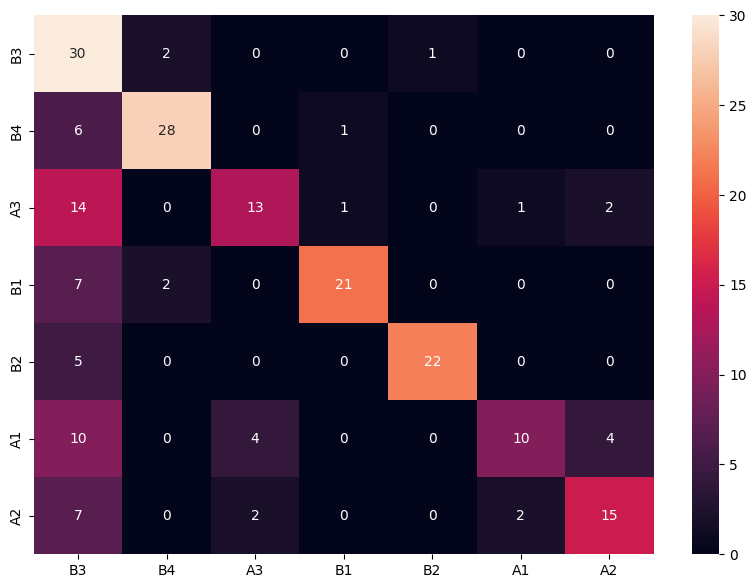

In [ ]:
evaluate_model(ensemble_val, y_hat, labels=class_to_index.keys(), ensemble=True)

<style>
    .styled-cell {
        border: 2px solid #3498db; /* Blue border color */
        background-color: #ecf0f1; /* Light-blue background color */
        border-radius: 10px; /* Rounded corners */
        padding: 10px; /* Padding for content inside the cell */
    }
</style>
<div class="styled-cell">
    <h2>Your Markdown Content</h2>
    <p>This is a styled text/markdown cell with a nice border, light-blue background color, and rounded corners.</p>
</div>

## Subtask 2: Second Pass (Multi-label)

Load train Test data for multi-label model.
`return_one_hot` gives one_hot_encoded labels.  
For multi-label model, the function returns a column with encoded list of labels; hence this variable is set to `True`.

In [ ]:
multiclass_train, multiclass_val = read_and_split_data(return_one_hot=True)

The follow code cells tokenize the `"Obs"` column and trains a simple sequential multi-label Deep Learning model on the same for each label-vector in the `"Type"` column.  

***Please note that since `TRAIN` is set to `False`, the training cell will not run. if you want to train the model in this session, set the parameter to True in the `HELPER FUNCTION section above.***

In [ ]:
# Tokenize your text data
tokenizer, max_len = tokenize_and_fit(multiclass_train["Obs"])
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
# Train a multi-label model

if TRAIN:
    X_data = encode_docs(tokenizer, max_len, multiclass_train["Obs"])
    binary_labels = [np.asarray(x, dtype = np.float64) for x in multiclass_train["Type"]]
    y_data = np.array(binary_labels)

    multi_label_model = create_multi_label_model(vocab_size=vocab_size,
                                                max_len=max_len,
                                                class_to_index=class_to_index,
                                                ensemble=False)
    multi_label_model.fit(X_data, y_data, epochs=30, batch_size=32, validation_split=0.2)

    # Save the model below
    save_model_s(multi_label_model, "multilabel_model")

Epoch 1/30
21/21 [==============================] - 1s 18ms/step - loss: 0.5475 - accuracy: 0.1354 - val_loss: 0.4105 - val_accuracy: 0.1905
Epoch 2/30
21/21 [==============================] - 0s 9ms/step - loss: 0.4025 - accuracy: 0.3438 - val_loss: 0.3973 - val_accuracy: 0.3869
Epoch 3/30
21/21 [==============================] - 0s 10ms/step - loss: 0.3659 - accuracy: 0.5893 - val_loss: 0.3687 - val_accuracy: 0.4940
Epoch 4/30
21/21 [==============================] - 0s 8ms/step - loss: 0.3136 - accuracy: 0.7812 - val_loss: 0.3275 - val_accuracy: 0.5417
Epoch 5/30
21/21 [==============================] - 0s 10ms/step - loss: 0.2485 - accuracy: 0.8452 - val_loss: 0.2824 - val_accuracy: 0.6369
Epoch 6/30
21/21 [==============================] - 0s 9ms/step - loss: 0.1868 - accuracy: 0.9107 - val_loss: 0.2470 - val_accuracy: 0.6786
Epoch 7/30
21/21 [==============================] - 0s 8ms/step - loss: 0.1336 - accuracy: 0.9554 - val_loss: 0.2175 - val_accuracy: 0.7321
Epoch 8/30
21/21 

In [ ]:
# Load the model
model = load_model_s(ensemble=False, name_prefix='multilabel_model', class_to_index=class_to_index)

y_hat = get_predictions(model, multiclass_val, ensemble=False)

7/7 [==============================] - 0s 2ms/step


We are reusing the helper functions with ensemble=False below.

Ensemble Classification Report:
              precision    recall  f1-score   support

          B3       0.94      0.45      0.61        33
          B4       0.85      0.49      0.62        35
          A3       0.80      0.39      0.52        31
          B1       0.95      0.70      0.81        30
          B2       0.89      0.63      0.74        27
          A1       0.71      0.43      0.53        28
          A2       0.68      0.58      0.62        26

   micro avg       0.83      0.52      0.64       210
   macro avg       0.83      0.52      0.64       210
weighted avg       0.84      0.52      0.64       210
 samples avg       0.52      0.52      0.52       210



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


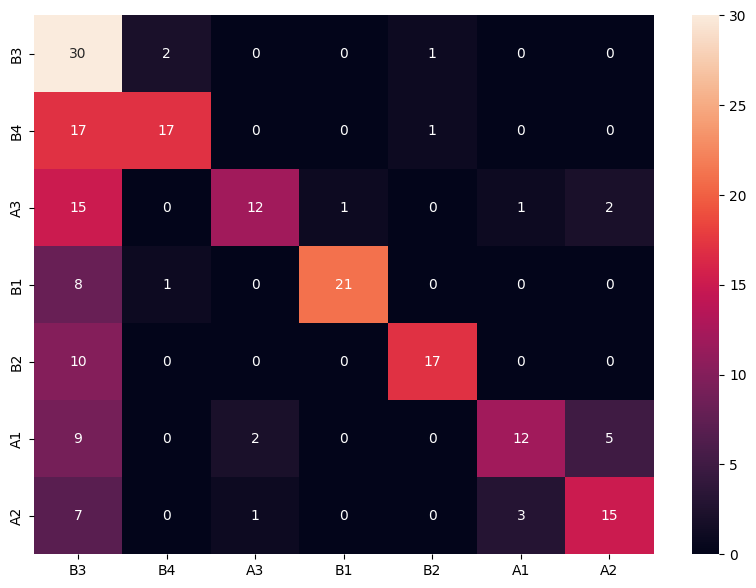

In [ ]:
evaluate_model(y_hat=y_hat, val_data=multiclass_val,labels=class_to_index.keys(), ensemble=False)

<style>
    .styled-cell {
        border: 2px solid #3498db; /* Blue border color */
        background-color: #ecf0f1; /* Light-blue background color */
        border-radius: 10px; /* Rounded corners */
        padding: 10px; /* Padding for content inside the cell */
    }
</style>
<div class="styled-cell">
    <h2>Your Markdown Content</h2>
    <p>This is a styled text/markdown cell with a nice border, light-blue background color, and rounded corners.</p>
</div>

## Third Pass (BERT)

Fetching fine-tuned model from g-drive for backup

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uCR3DMq0BATJaJwPylP2YW_Pn5gGkfLd&confirm=t' -r -A 'uc*' -e robots=off -nd -O 'fine_tuned_bert_model_tf.zip'

Loading Train Test data for BERT model

In [5]:
bert_train, bert_val = read_and_split_data(return_one_hot=True)

Using `bert-base-uncased` model becase of te size of the training sample bein `<1000`.  
Also, the data can be handled in lowercase format.  

Using BertTokenizer with Tensorflow to avoid complications with compute capacities.

In [6]:

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=len(df['Type'].unique()))


train_inputs = tokenizer.batch_encode_plus(list(bert_train['Obs']), add_special_tokens=True, padding=True, truncation=True, return_tensors='np', max_length=tokenizer.model_max_length)
val_inputs = tokenizer.batch_encode_plus(list(bert_val['Obs']), add_special_tokens=True, padding=True, truncation=True, return_tensors='np', max_length=tokenizer.model_max_length)


train_labels = tf.convert_to_tensor([label for label in bert_train["Type"]])
val_labels = tf.convert_to_tensor([label for label in bert_val["Type"]])




All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You can set thhe following to `True`, although for this part, TPU was used for faster training (which took 300 seconds ~ around 5 minutes).
On CPU this cell would take more than an hour to run 10 epochs.

In [7]:
if TRAIN:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[Precision(), Recall()])

    history = model.fit(dict(train_inputs), train_labels,
                        epochs=10,
                        batch_size=8,
                        validation_data=(dict(val_inputs), val_labels)
            )

    # Save the fine-tuned model
    model.save_pretrained('/content/fine_tuned_bert_model_tf')

Epoch 1/10
105/105 [==============================] - 83s 174ms/step - loss: 1.4846 - precision: 0.4302 - recall: 0.5060 - val_loss: 0.9127 - val_precision: 0.4739 - val_recall: 0.9095
Epoch 2/10
105/105 [==============================] - 12s 113ms/step - loss: 0.6276 - precision: 0.4809 - recall: 0.9762 - val_loss: 0.7676 - val_precision: 0.5108 - val_recall: 0.9000
Epoch 3/10
105/105 [==============================] - 12s 118ms/step - loss: 0.3195 - precision: 0.5669 - recall: 0.9940 - val_loss: 0.7117 - val_precision: 0.5282 - val_recall: 0.9381
Epoch 4/10
105/105 [==============================] - 12s 112ms/step - loss: 0.1684 - precision: 0.6433 - recall: 0.9940 - val_loss: 0.7241 - val_precision: 0.5714 - val_recall: 0.9143
Epoch 5/10
105/105 [==============================] - 12s 113ms/step - loss: 0.1094 - precision: 0.7218 - recall: 0.9976 - val_loss: 0.7671 - val_precision: 0.5698 - val_recall: 0.9333
Epoch 6/10
105/105 [==============================] - 11s 108ms/step - loss

In [44]:
import os

if os.path.exists('/content/fine_tuned_bert_model_tf'):
    # Load the fine-tuned model
    fine_tuned_model_tf = TFBertForSequenceClassification.from_pretrained('/content/fine_tuned_bert_model_tf')
else:
    !unzip '/content/fine_tuned_bert_model_tf' -d "/content"
    fine_tuned_model_tf = TFBertForSequenceClassification.from_pretrained('/content/fine_tuned_bert_model_tf')

True

Evaluation predictions

In [46]:
val_preds_tf = fine_tuned_model_tf.predict(dict(val_inputs))['logits']
val_preds_tf = tf.math.sigmoid(val_preds_tf)
y_hat = (val_preds_tf > 0.5).numpy()


7/7 [==============================] - 1s 87ms/step


Ensemble Classification Report:
              precision    recall  f1-score   support

          B3       0.63      0.94      0.76        33
          B4       0.83      1.00      0.91        35
          A3       0.40      0.94      0.56        31
          B1       0.64      0.93      0.76        30
          B2       0.76      0.96      0.85        27
          A1       0.55      0.75      0.64        28
          A2       0.36      0.85      0.51        26

   micro avg       0.56      0.91      0.70       210
   macro avg       0.60      0.91      0.71       210
weighted avg       0.61      0.91      0.72       210
 samples avg       0.66      0.91      0.74       210



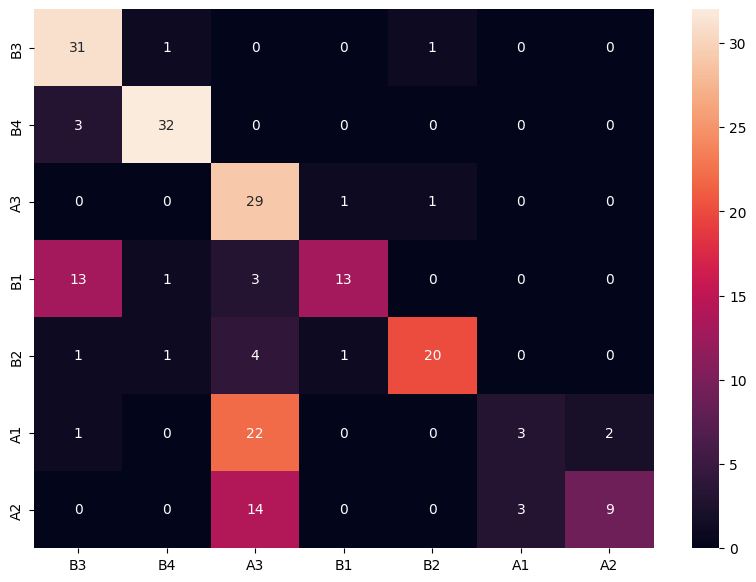

In [47]:
evaluate_model(val_data=bert_val, ensemble=False, labels=class_to_index.keys(), y_hat=y_hat)

<style>
    .styled-cell {
        border: 2px solid #3498db; /* Blue border color */
        background-color: #ecf0f1; /* Light-blue background color */
        border-radius: 10px; /* Rounded corners */
        padding: 10px; /* Padding for content inside the cell */
    }
</style>
<div class="styled-cell">
    <h2>Your Markdown Content</h2>
    <p>This is a styled text/markdown cell with a nice border, light-blue background color, and rounded corners.</p>
</div>

## Evaluation

Label-wise comparison (all 7 labels) for precision, recall and F1-scores

In [16]:
from sklearn.metrics import precision_recall_fscore_support

Calculating scores

In [18]:
prec, rec, f1_, sup = precision_recall_fscore_support(y_true=val_labels.numpy(), y_pred=binary_val_preds_tf)

Plotting

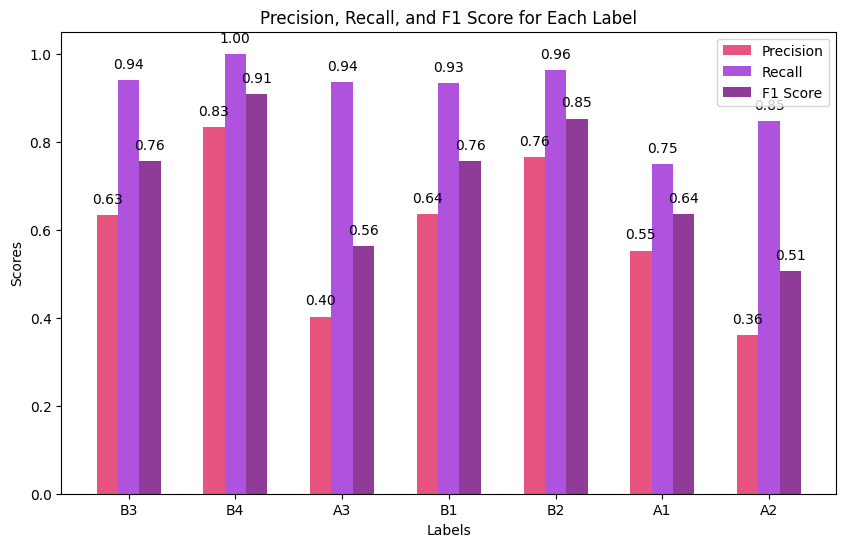

In [29]:
precision_color = '#E75480'
recall_color = '#AF52DE'
f1_color = '#8F3C98'

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(class_to_index.keys()))

bar1 = ax.bar(index - bar_width, prec, bar_width, label='Precision', color=precision_color)
bar2 = ax.bar(index, rec, bar_width, label='Recall', color=recall_color)
bar3 = ax.bar(index + bar_width, f1_, bar_width, label='F1 Score', color=f1_color)

# Adding annotations on top of each bar
for bars, scores in zip([bar1, bar2, bar3], [prec, rec, f1_]):
    for bar, score in zip(bars, scores):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.2f}', ha='center', va='bottom')


ax.set_xlabel('Labels')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for Each Label')
ax.set_xticks(index)
ax.set_xticklabels(class_to_index.keys())
ax.legend()

plt.show()


<style>
    .styled-cell {
        border: 2px solid #3498db; /* Blue border color */
        background-color: #ecf0f1; /* Light-blue background color */
        border-radius: 10px; /* Rounded corners */
        padding: 10px; /* Padding for content inside the cell */
    }
</style>
<div class="styled-cell">
    <h2>Your Markdown Content</h2>
    <p>This is a styled text/markdown cell with a nice border, light-blue background color, and rounded corners.</p>
</div>

### Bibliography

*   [multi-label-text-classification](https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d)
*   Stackoverflow was used in the process of debugging errors.



Please reach out to visalakshiiyer@arizona.edu in case of any shortcomings with the notebook.